#### Lab 3 - VGG16

umu-id: anth2786

On specific places in the Notebook, the code is adapted from code on some web guide. It is mentioned which webpage on the specific box below. Here is a summary:
- https://www.reddit.com/r/tensorflow/comments/i4mx5v/classify_fashion_mnist_with_vgg16_question/
- https://towardsdatascience.com/feature-visualization-on-convolutional-neural-networks-keras-5561a116d1af
- https://github.com/keras-team/keras-tuner/issues/122
- https://maelfabien.github.io/deeplearning/xception/

!!! Note that directory in the tuners have to be changed depending on your development environment !!!


In [1]:
import tensorflow as tf
print('Tensorflow version:', tf.__version__)

# Allocating all the memory on the local GPU will lead to failure in initialising cuDNN
# This is needed so Tensorflow does not allocate all memory on the GPU at once. 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#session = InteractiveSession.Session(config=config)

# Use Tensorflow Keras
import tensorflow.keras
print('Keras version:', tensorflow.keras.__version__)
# Import Early stopping which stops traing whan a monitored metric has been reached
from tensorflow.keras.callbacks import EarlyStopping
# Import Dense, which is a "normal" NN layer with the function output = activation(dot(input, kernel) + bias)
from tensorflow.keras.layers import Dense
# Import Dropout. Dropout prvents overfitting by applying 0 as input units randomly, during trainng (only training)
from tensorflow.keras.layers import Dropout
# Import Regularizers. Makes it possible to apply penalties on activity, bias or kernel. It is applied per layer
from tensorflow.keras import regularizers

Tensorflow version: 2.3.1
Keras version: 2.4.0


In [2]:
# Nicely formatted time string
import time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

#### Import MNIST Fashion Set

In [3]:
# Import the Fashoin MNIST dataset, which is part of Keras
from tensorflow.keras.datasets import fashion_mnist
import sklearn
# import a method to split traning data into two parts; training and validation data
from sklearn.model_selection import train_test_split

# Get the data from the Keras Database
(x_train0, y_train0), (x_test, y_test) = fashion_mnist.load_data()

# Split the training set into a trainng and a validation set (15% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train0, y_train0, test_size = 0.15)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(51000, 28, 28)
(51000,)
(10000, 28, 28)
(10000,)


###### Remodel the MNIST Fashion images to work in VG16

In [4]:
# This code is inspired by code on the webpage
#   https://www.reddit.com/r/tensorflow/comments/i4mx5v/classify_fashion_mnist_with_vgg16_question/

# Number of categories in mnist fashion
nr_cat_mnist_fashion = 10

# reshape dataset to have a single channel
train_images1 = x_train.reshape((x_train.shape[0], 28, 28, 1))
test_images1 = x_test.reshape((x_test.shape[0], 28, 28, 1))

# transform to rgb as required by VGG
train_images1=tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=3))
test_images1=tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=3))

#resize to minimum size of (32x32)
x_train=tf.image.resize_with_pad(train_images1,32,32)
x_test=tf.image.resize_with_pad(test_images1,32,32)

# Converts a class vector (integers) to binary class matrix.
#   eg, converts the class vector into a numpy array / matrix whith nr of columns equal 
#   to the number of categories in the data
y_train = tensorflow.keras.utils.to_categorical(y_train, nr_cat_mnist_fashion)
y_test = tensorflow.keras.utils.to_categorical(y_test, nr_cat_mnist_fashion)

print(x_train.shape)
print(x_test.shape)


(51000, 32, 32, 3)
(10000, 32, 32, 3)


###### Plot the pictures to see that the transformation was ok

<Figure size 432x288 with 0 Axes>

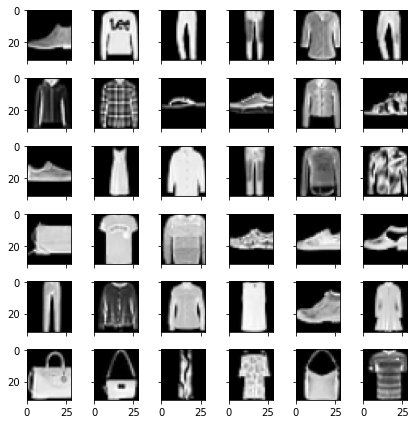

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np

ROWS = 6
plt.clf()

# Make small axes for the images
fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

# Plot the images in a matrix ROWS x ROWS
for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS

    # plot the subaxes'
    ax = axes[subplot_row, subplot_col]

    # Pick the image
    label = y_test[i]
    plottable_image = x_test[i]/np.amax(x_test[i])

    # Make an image
    ax.imshow(plottable_image, cmap='gray_r')
    
    # Set the numerical bounds of the x-axis
    ax.set_xbound([0,28])

# plot it to the webpage
plt.tight_layout()
plt.show()

#### Import VGG16

In [5]:
PIXEL = 32

In [6]:
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D


# This downloads 554 MB data (100 mbps line => 45-60 sec)
# include_top = True includes 3 fully-connected alyers at the top of the network
# It utilzes 1000 prepared classes. 
# If include_top = True, then input_shape can not be used, it will default to (224,224,3). Use:
#   vggmodelWithTop = keras.applications.VGG16(weights='imagenet', include_top=True)
# We will not use default, but 32x32 (closest to NMIST Fashion) and 10 classes (the 10 MNIST Fashion classes)

base_model = tensorflow.keras.applications.VGG16(input_shape=(PIXEL,PIXEL,3), weights='imagenet', include_top=False)

#### First test Analysis

At this point an analysis on how many layers of the VGG16 model should be used. Around 20 tests with a sequential model an fit was done. It was made with 3, 2 and 1 VGG16 layers. Using 3 and 2 of the VGG16 layers was not successful with accuracy around 40%. This could have been due to that the pictures was in the wrong format, or some other reason, but running with 1 VGG16 layer performed well. Therefore Tuning was made with 1 pretrained layer of the VGG16 model.
Looking at https://towardsdatascience.com/feature-visualization-on-convolutional-neural-networks-keras-5561a116d1af we can see that even the second convolutional layer start to have some patterns that is more complex. That might be a reason why using only layer 1 gave a better result in the initial tests.

#### Start tuning

###### Make subclass tuner that overrides the default

In [7]:
# Inspired by https://github.com/keras-team/keras-tuner/issues/122

import kerastuner
class MyTuner(kerastuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 192, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 25, 25)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

###### Build the function

In [8]:
import os.path
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.models import Model

def build_model2(hp):

    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in base_model.layers])

    # Getting output tensor of the last VGG layer that we want to include
    xlo = layer_dict['block1_pool'].output

    # Choose different number of convolution layers (between 1 and 3). Try filters of 32-224
    cnt = 0
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        xlo = Conv2D(filters=hp.Choice('num_filters_1',values=[32,64,96,128,192,224], default=96),
                   kernel_size=(3, 3),
                   activation='relu')(xlo)
        cnt = cnt + 1
 
    # Test dropout of 0, 0.2, 0.4 or 0.6
    xlo = Dropout(rate=hp.Float('dropout_conv_1',min_value=0, max_value=0.6, default=0.2, step=0.2))(xlo)

    # Flatten
    xlo = Flatten()(xlo)

    # 1 to 4 dense layers with neurons/units between 64 and 1024
    for i2 in range(hp.Int('num_dense_layers', 1, 4)):
        xlo = Dense(units=hp.Int('dense_units', 
                                  min_value = 64, 
                                  max_value=1024, 
                                  step=128), activation='relu')(xlo)
        
        # Test dropout of 0, 0.25 or 0.5
        xlo = Dropout(rate=hp.Float('dropout_dense_1',min_value=0, max_value=0.5, default=0.25, step=0.25))(xlo)

    xlo = Dense(10, activation='softmax')(xlo)

    # Creating the new model
    model9 = Model(base_model.input, xlo)

    # Make sure that the pre-trained bottom layers are not trainable
    for layer in model9.layers[:4]:
        layer.trainable = False
    
    
    model9.summary()
    model9.compile(loss='categorical_crossentropy', 
                   optimizer=keras.optimizers.Adam(
                        learning_rate=0.0006475221645231884,
                       name='Adam'
                    ),
                  metrics=['accuracy'])
    
    print("compiled")
    return model9

###### Make the tuner

In [11]:
# !!! Note that directory have to be changed depending on your development environment !!!

tuner2 = MyTuner(
    build_model2,
    objective='val_accuracy',
    max_trials=96,
    executions_per_trial=1,
    overwrite=True,    
    project_name='umu_labb3_part1',
    directory=os.path.normpath('c:/kerasloggs/labb3b')
    )

print("Search space summary ************ RANDOM ********************************************")
tuner2.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project c:\kerasloggs\labb3b\umu_labb3_part1\oracle.json
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
________________

In [12]:
print("#################################################################################")
print("################### RANDOM SEARCH ###############################################")
print("#################################################################################")
print("")

## Batch size and epochs will be changed/overidden to the values in the tuner subclass
batch_size=64
epochs = 25

start_time = time.time()

early_stopping = EarlyStopping(
    patience=8,
    mode='auto')

tuner2.search(x_train, y_train,
          batch_size=batch_size,
          verbose=2,             
          epochs=epochs,
          validation_split=0.1,
            callbacks=[early_stopping])




print("Search over")

models = tuner2.get_best_models(num_models=1)
best_model = models[0]

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

---------------------------------------------------------------------------------
------------------ SEARCH -------------------------------------------------------
---------------------------------------------------------------------------------

#################################################################################
################### RANDOM SEARCH ###############################################
#################################################################################
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_______________________

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 224)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43904)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 224)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43904)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 224)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43904)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 224)       0         
_________________________________________________________________
flatten (Flatten)            (None, 43904)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 96)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 224)       129248    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 224)       451808    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 224)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 192)       0         
_________________________________________________________________
flatten (Flatten)            (None, 37632)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)       

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 192)       0         
_________________________________________________________________
flatten (Flatten)            (None, 37632)            

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 96)        55392     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18816)            

INFO:tensorflow:Oracle triggered exit
Search over
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv

#### Analysis of the tuning

The best I-score is 0,921569. We will build a model from that run. We can also see some kind of error in the layer output Err:510<br>


input_1 (InputLayer)         [(None, 32, 32, 3)]       0         <br>
_________________________________________________________________<br>
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      <br>
_________________________________________________________________<br>
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     <br>
_________________________________________________________________<br>
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         <br>
_________________________________________________________________<br>
conv2d (Conv2D)              (None, 14, 14, 192)       110784    <br>
_________________________________________________________________<br>
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    <br>
_________________________________________________________________<br>
conv2d_2 (Conv2D)            (None, 10, 10, 192)       331968    <br>
_________________________________________________________________<br>
dropout (Dropout)            (None, 10, 10, 192)       0         <br>
_________________________________________________________________<br>
flatten (Flatten)            (None, 19200)             0         <br>
_________________________________________________________________<br>
dense (Dense)                (None, 832)               15975232  <br>
_________________________________________________________________<br>
dropout_1 (Dropout)          (None, 832)               0         <br>
_________________________________________________________________<br>
dense_1 (Dense)              (None, 832)               693056    <br>
_________________________________________________________________<br>
dropout_2 (Dropout)          (None, 832)               0         <br>
_________________________________________________________________<br>
dense_2 (Dense)              (None, 832)               693056    <br>
_________________________________________________________________<br>
dropout_3 (Dropout)          (None, 832)               0         <br>
_________________________________________________________________<br>
dense_3 (Dense)              (None, 10)                8330      <br>
<br>
Trial summary<br>
|-Trial ID: 18ffb9e644a3d3d7a61deebc475ea714<br>
|-Score: 0.9215686321258545<br>
|-Best step: 0<br>
Hyperparameters:<br>
|-batch_size: 128<br>
|-dense_units: 832<br>
|-dropout_conv_1: 0.6000000000000001<br>
|-dropout_dense_1: 0.0<br>
|-epochs: 25<br>
|-num_conv_layers: 3<br>
|-num_dense_layers: 3<br>
|-num_filters_1: 192<br>



#### Build the model

In [7]:
from tensorflow.keras.layers import MaxPooling2D, LeakyReLU
# Creating dictionary that maps layer names to the layers
layer_dict2 = dict([(layer.name, layer) for layer in base_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x2 = layer_dict2['block1_pool'].output

# Stacking Layers on top of it
x2 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x2)
x2 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x2)
x2 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x2)
x2 = Dropout(0.6)(x2)
x2 = Flatten()(x2)
x2 = Dense(832, activation='relu')(x2)
x2 = Dense(832, activation='relu')(x2)
x2 = Dense(832, activation='relu')(x2)
x2 = Dense(10, activation='softmax')(x2)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
model2 = Model(base_model.input, x2)


# Make sure that the pre-trained bottom layers are not trainable
for layer in model2.layers[:4]:
    layer.trainable = False

# Compile
model2.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

model2.summary()

for layer in model2.layers:
    sp = '     '[len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

###### Train the model

In [8]:
# Split of the traing set into 10% validation is done in the model fit

batch_size = 128
epochs = 30

early_stopping = EarlyStopping(
    patience=4,
    mode='auto')

start_time = time.time()
history2 = model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,
        callbacks=[early_stopping]
)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/30
359/359 - 6s - loss: 8.3265 - accuracy: 0.1006 - val_loss: 2.2829 - val_accuracy: 0.1076
Epoch 2/30
359/359 - 6s - loss: 2.2365 - accuracy: 0.1330 - val_loss: 1.7446 - val_accuracy: 0.3208
Epoch 3/30
359/359 - 6s - loss: 1.5038 - accuracy: 0.3785 - val_loss: 1.0073 - val_accuracy: 0.5947
Epoch 4/30
359/359 - 6s - loss: 0.7844 - accuracy: 0.6868 - val_loss: 0.6076 - val_accuracy: 0.7631
Epoch 5/30
359/359 - 6s - loss: 0.5827 - accuracy: 0.7798 - val_loss: 0.4640 - val_accuracy: 0.8282
Epoch 6/30
359/359 - 6s - loss: 0.4800 - accuracy: 0.8226 - val_loss: 0.3849 - val_accuracy: 0.8590
Epoch 7/30
359/359 - 6s - loss: 0.4219 - accuracy: 0.8470 - val_loss: 0.3582 - val_accuracy: 0.8692
Epoch 8/30
359/359 - 6s - loss: 0.3856 - accuracy: 0.8586 - val_loss: 0.3404 - val_accuracy: 0.8747
Epoch 9/30
359/359 - 6s - loss: 0.3519 - accuracy: 0.8718 - val_loss: 0.3098 - val_accuracy: 0.8861
Epoch 10/30
359/359 - 6s - loss: 0.3408 - accuracy: 0.8756 - val_loss: 0.3084 - val_accuracy: 0.8847

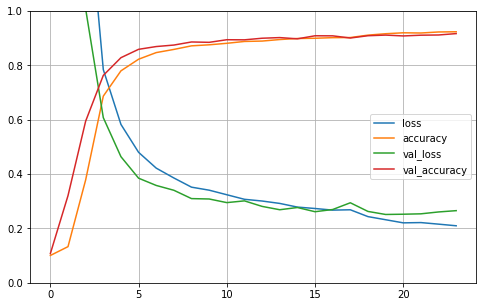

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [12]:
start_time = time.time()

score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Test loss: 0.28854110836982727
Test accuracy: 0.9075000286102295
Elapsed time: 0:00:01.10


###### Analysis of the result

Running the evaluation on the test set gives a 90,7% Accuracy. This is too low compared to the target of 91.5%
Looking at the hyper parameters there are a few that were on the limits:<br>
- Dropout 0.6<br>
- Filters 196<br>
<br>
In order to achieve a better result, we will therefore make a new tuning with tuning values on these parameters. We will also add the possibility for a MaxPooling layer, and different learning rates. As well as trying a few more batch sizes. Looking in the tuning results, the batch size that seems most promising (better accuracy earlier) is 192 (on the limit). We will also use 5 more epochs in case the learning is slower


#### 2nd Tuner

Use the best result

Trial summary
|-Trial ID: 18ffb9e644a3d3d7a61deebc475ea714
|-Score: 0.9215686321258545
|-Best step: 0
Hyperparameters:
|-batch_size: 128
|-dense_units: 832
|-dropout_conv_1: 0.6000000000000001
|-dropout_dense_1: 0.0
|-epochs: 25
|-num_conv_layers: 3
|-num_dense_layers: 3
|-num_filters_1: 192

###### Make subclass tuner that overrides the default

In [7]:
# New batch sizes 192 and to 288, 30 epochs

import kerastuner
class MyTuner3(kerastuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 192, 288, step=32)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 30, 30)
    super(MyTuner3, self).run_trial(trial, *args, **kwargs)

###### Build the function

In [17]:
import os.path
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras.models import Model
from tensorflow.keras.layers import MaxPooling2D


def build_model3(hp):

    # Creating dictionary that maps layer names to the layers
    layer_dict3 = dict([(layer.name, layer) for layer in base_model.layers])

    # Getting output tensor of the last VGG layer that we want to include
    xlo3 = layer_dict3['block1_pool'].output

    # Choose different number of convolution layers with 192 filters
    xlo3 = Conv2D(192, kernel_size=(3, 3), activation='relu')(xlo3)
    xlo3 = Conv2D(192, kernel_size=(3, 3), activation='relu')(xlo3)
    # Add 0 or 1 MaxPooling layer
    for i2 in range(hp.Int('num_maxpool_layers', 0, 1)):
        xlo3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(xlo3)
    xlo3 = Conv2D(192, kernel_size=(3, 3), activation='relu')(xlo3)
 
    # Try new dropout values 0.5,0.6 and 0.7
    xlo3 = Dropout(rate=hp.Float('dropout_conv_1',min_value=0.5, max_value=0.7, default=0.1, step=0.6))(xlo3)

    # Flatten
    xlo3 = Flatten()(xlo3)

    # Dense layers with 832 neurons/inots
    xlo3 = Dense(832, activation='relu')(xlo3)
    xlo3 = Dense(832, activation='relu')(xlo3)
    xlo3 = Dense(832, activation='relu')(xlo3)
    
    # Output
    xlo3 = Dense(10, activation='softmax')(xlo3)

    # Creating new model. Please note that this is NOT a Sequential() model.
    model3 = Model(base_model.input, xlo3)

    # Make sure that the pre-trained bottom layers are not trainable
    # Block1_pool
    for layer in model3.layers[:4]:
        layer.trainable = False
    
    
    model3.summary()
    
    # Try different learning rates
    model3.compile(loss='categorical_crossentropy', 
                    optimizer=keras.optimizers.Adam(
                        hp.Float(
                            'learning_rate',
                            min_value=1e-4,
                            max_value=1e-2,
                            sampling='LOG',
                            default=1e-3
                        )
                        ),
                      metrics=['accuracy'])

    print("compiled")
    return model3

###### Make the tuner

In [12]:
# !!! Note that directory have to be changed depending on your development environment !!!

tuner3 = MyTuner3(
    build_model3,
    objective='val_accuracy',
    max_trials=96,
    executions_per_trial=1,
    overwrite=True,    
    project_name='umu_labb3_part1b',
    directory=os.path.normpath('c:/kerasloggs/labb3b')
    )

print("Search space summary ************ RANDOM ********************************************")
tuner3.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project c:\kerasloggs\labb3b\umu_labb3_part1b\oracle.json
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_______________

In [13]:
print("#################################################################################")
print("################### RANDOM SEARCH ###############################################")
print("#################################################################################")

batch_size=128
epochs = 30

start_time = time.time()

early_stopping = EarlyStopping(
    patience=8,
    mode='auto')

tuner3.search(x_train, y_train,
          batch_size=batch_size,
          verbose=2,             
          epochs=epochs,
          validation_split=0.1,
            callbacks=[early_stopping])




print("Search over")

models = tuner3.get_best_models(num_models=1)
best_model = models[0]

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

---------------------------------------------------------------------------------
------------------ SEARCH -------------------------------------------------------
---------------------------------------------------------------------------------

#################################################################################
################### RANDOM SEARCH ###############################################
#################################################################################
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_______________________

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 192)      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 192)        

INFO:tensorflow:Oracle triggered exit
Search over
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_

###### Analysis

The three best results have 1 maxpool layer, drouput on the conv layer of 0.5
Two of the three have a batch size of 224, and the third 192<br>
They have the following learning rates<br>
- 0.0002957564285137658<br>
- 0.000605468468761364<br>
- 0.0003935798382031843<br>
<br><br>
So we build a model with 1 maxpool, dropout of 0.5, batch of 224 and learning rate of 0.0006...<br>

###### Build the "best model" after the 2nd Tuning

In [14]:
from tensorflow.keras.layers import MaxPooling2D, LeakyReLU

# Creating dictionary that maps layer names to the layers
layer_dict3 = dict([(layer.name, layer) for layer in base_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x3 = layer_dict3['block1_pool'].output


# Stacking a new simple convolutional network on top of it    
x3 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x3)
x3 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x3)
x3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x3)
x3 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = Flatten()(x3)
x3 = Dense(832, activation='relu')(x3)
x3 = Dense(832, activation='relu')(x3)
x3 = Dense(832, activation='relu')(x3)
x3 = Dense(10, activation='softmax')(x3)


# Creating new model. 
from keras.models import Model
model3 = Model(base_model.input, x3)


# Make sure that the pre-trained bottom layers are not trainable
# Block1_pool
for layer in model3.layers[:4]:
    layer.trainable = False

# Compile
model3.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(
                    learning_rate=0.000605468468761364,
                    name='Adam'
                    ),
                    metrics=['accuracy'])

model3.summary()

for layer in model3.layers:
    sp = '     '[len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 192)        

###### Train the model

In [15]:
batch_size = 224
epochs = 30

early_stopping = EarlyStopping(
    patience=8,
    mode='auto')

start_time = time.time()
history3 = model3.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,                      
        callbacks=[early_stopping]
)



elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/30
205/205 - 4s - loss: 6.2017 - accuracy: 0.3000 - val_loss: 1.3716 - val_accuracy: 0.4271
Epoch 2/30
205/205 - 4s - loss: 1.2471 - accuracy: 0.4934 - val_loss: 0.8535 - val_accuracy: 0.6684
Epoch 3/30
205/205 - 4s - loss: 0.8615 - accuracy: 0.6567 - val_loss: 0.6521 - val_accuracy: 0.7398
Epoch 4/30
205/205 - 4s - loss: 0.6359 - accuracy: 0.7534 - val_loss: 0.5189 - val_accuracy: 0.8065
Epoch 5/30
205/205 - 4s - loss: 0.5497 - accuracy: 0.7918 - val_loss: 0.4557 - val_accuracy: 0.8378
Epoch 6/30
205/205 - 4s - loss: 0.4906 - accuracy: 0.8165 - val_loss: 0.4070 - val_accuracy: 0.8620
Epoch 7/30
205/205 - 4s - loss: 0.4395 - accuracy: 0.8390 - val_loss: 0.3559 - val_accuracy: 0.8657
Epoch 8/30
205/205 - 4s - loss: 0.4030 - accuracy: 0.8513 - val_loss: 0.3352 - val_accuracy: 0.8839
Epoch 9/30
205/205 - 4s - loss: 0.3716 - accuracy: 0.8634 - val_loss: 0.3085 - val_accuracy: 0.8871
Epoch 10/30
205/205 - 4s - loss: 0.3486 - accuracy: 0.8730 - val_loss: 0.2839 - val_accuracy: 0.8953

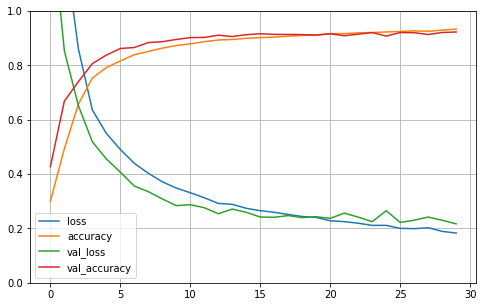

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [17]:
start_time = time.time()

score = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Test loss: 0.23381829261779785
Test accuracy: 0.9197999835014343
Elapsed time: 0:00:01.30


#### Analysis

The accuracy of the evaluation is above the target of 91.5%<br>
<br>
In this model we have 2 conv layers with 1 MaxPool and the 1 mode conlayer with Dropout
After that flattering and 3 dense layers with 832 neurons/units, without dropouts.
<br><br>
In the previous task without the pretrained VGG16, the layers had a start of 3 conv layers + a maxpool. This could be compared with the pretrained VGG16 first layer, even if it is not the same number of filters.
Then comes 2 conv layers with a dropout. In this model it was also (as stated above) 1 Maxpool and 1 conv.
<br><br>
After that both models flatten. The previous model had 2 Dense layers with 192 neurons/units and a dropout for each of those. That is rather different to the 3 dense layers with 832 neurons/units. Also some tests (not documented in this task) were done with dropout on the 3 dense layers, but the results came with low accuracy.
<br><br>
The two models have a similar learning rate and both use Adam.
<br><br>
Using the VGG16 model on the MNIST Fashion set were in this task not successful. The test accuracy were lower (0,9198 compared to 0.9247), and the test loss were hight (0,2338 compared to 0.2187). One reason could be that the MNIST Fashion pictures comes with a very low resolution compared to how the VGG16 model is trained (28x28 vs 224x224), and thus have different shapes in the lower layers (and higher levels). Another reason could be that the transformation in this task could be handled in a better way.
<br><br>
It would be interesting to se others attempt on this task


#### Part B - VG part 1 of 2

Take the same model, but without freezing the pretrained models layers

In [8]:
from tensorflow.keras.layers import MaxPooling2D, LeakyReLU

# Creating dictionary that maps layer names to the layers
layer_dict5 = dict([(layer.name, layer) for layer in base_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x5 = layer_dict5['block1_pool'].output


# Stacking a new simple convolutional network on top of it    
x5 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x5)
x5 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x5)
x5 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x5)
x5 = Conv2D(filters=192, kernel_size=(3, 3), activation='relu')(x5)
x5 = Dropout(0.5)(x5)
x5 = Flatten()(x5)
x5 = Dense(832, activation='relu')(x5)
x5 = Dense(832, activation='relu')(x5)
x5 = Dense(832, activation='relu')(x5)
x5 = Dense(10, activation='softmax')(x5)


# Creating new model. 
from keras.models import Model
model5 = Model(base_model.input, x5)


# Make sure that the pre-trained bottom layers are not trainable
# Block1_pool
#for layer in model3.layers[:4]:
#    layer.trainable = False

# Compile
model5.compile(loss='categorical_crossentropy',
                    optimizer=tensorflow.keras.optimizers.Adam(
                    learning_rate=0.000605468468761364,
                    name='Adam'
                    ),
                    metrics=['accuracy'])

model5.summary()

for layer in model5.layers:
    sp = '     '[len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 192)       110784    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 192)       331968    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 192)        

In [9]:
batch_size = 224
epochs = 30

early_stopping = EarlyStopping(
    patience=8,
    mode='auto')

start_time = time.time()
history5 = model5.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,                      
        callbacks=[early_stopping]
)



elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/30
205/205 - 6s - loss: 7.0714 - accuracy: 0.1915 - val_loss: 1.7171 - val_accuracy: 0.3147
Epoch 2/30
205/205 - 5s - loss: 1.5571 - accuracy: 0.3518 - val_loss: 1.3527 - val_accuracy: 0.4378
Epoch 3/30
205/205 - 5s - loss: 1.3222 - accuracy: 0.4422 - val_loss: 1.0860 - val_accuracy: 0.5798
Epoch 4/30
205/205 - 5s - loss: 1.0530 - accuracy: 0.5796 - val_loss: 0.8766 - val_accuracy: 0.6859
Epoch 5/30
205/205 - 5s - loss: 0.9092 - accuracy: 0.6446 - val_loss: 0.7406 - val_accuracy: 0.7675
Epoch 6/30
205/205 - 5s - loss: 0.6817 - accuracy: 0.7427 - val_loss: 0.5863 - val_accuracy: 0.8061
Epoch 7/30
205/205 - 5s - loss: 0.5792 - accuracy: 0.7853 - val_loss: 0.5011 - val_accuracy: 0.8451
Epoch 8/30
205/205 - 5s - loss: 0.5096 - accuracy: 0.8125 - val_loss: 0.4454 - val_accuracy: 0.8539
Epoch 9/30
205/205 - 5s - loss: 0.4649 - accuracy: 0.8281 - val_loss: 0.4066 - val_accuracy: 0.8561
Epoch 10/30
205/205 - 5s - loss: 0.4202 - accuracy: 0.8458 - val_loss: 0.3542 - val_accuracy: 0.8808

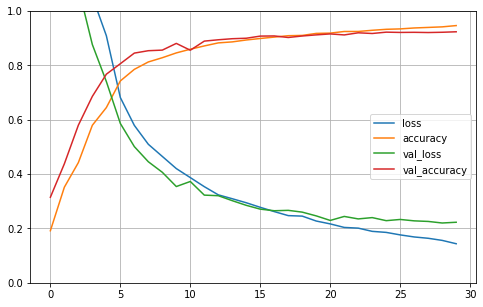

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history5.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [11]:
start_time = time.time()

score = model5.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Test loss: 0.23178566992282867
Test accuracy: 0.9215999841690063
Elapsed time: 0:00:01.24


###### Analysis

Comparing when all layers is trainable to when the pretrained layers where non-trainable, the accuracy started out lower.
However, the result is close to the same:<br>
val Acc: 0,921<br>
val Loss: 0,23<br>
vs.<br>
val Acc: 0,920<br>
val Loss: 0,23<br>
<br><br>
This might be beacuse only 1 block (out of 5) with 3 layers where choosen in the model where choosen to be used in the pre-
trained model.

#### VG Part 2 of 2

###### Xception have a minimum size of 71 on the images so we will remodel the MNIST Fashion set

In [3]:
PIXEL = 71

###### Remodel the MNIST data

In [4]:
# Import the Fashoin MNIST dataset, which is part of Keras
from tensorflow.keras.datasets import fashion_mnist
import sklearn
# import a method to split traning data into two parts; training and validation data
from sklearn.model_selection import train_test_split

# Get the data from the Keras Database
(x_train0_xc, y_train0_xc), (x_test_xc, y_test_xc) = fashion_mnist.load_data()

# Split the training set into a trainng and a validation set (15% validation)
x_train_xc, x_val_xc, y_train_xc, y_val_Xc = train_test_split(x_train0_xc, y_train0_xc, test_size = 0.15)

print(x_train_xc.shape)
print(y_train_xc.shape)
print(x_test_xc.shape)
print(y_test_xc.shape)

(51000, 28, 28)
(51000,)
(10000, 28, 28)
(10000,)


In [5]:
# This code is inspired by code on the webpage
#   https://www.reddit.com/r/tensorflow/comments/i4mx5v/classify_fashion_mnist_with_vgg16_question/

# Number of categories in mnist fashion
nr_cat_mnist_fashion = 10

# reshape dataset to have a single channel
train_images1_xc = x_train_xc.reshape((x_train_xc.shape[0], 28, 28, 1))
test_images1_xc = x_test_xc.reshape((x_test_xc.shape[0], 28, 28, 1))

# transform to rgb as required by VGG
train_images1_xc=tf.image.grayscale_to_rgb(tf.expand_dims(x_train_xc, axis=3))
test_images1_xc=tf.image.grayscale_to_rgb(tf.expand_dims(x_test_xc, axis=3))

#resize to minimum size of (71x71)
x_train_xc=tf.image.resize_with_pad(train_images1_xc,71,71)
x_test_xc=tf.image.resize_with_pad(test_images1_xc,71,71)

# Converts a class vector (integers) to binary class matrix.
#   eg, converts the class vector into a numpy array / matrix whith nr of columns equal 
#   to the number of categories in the data

y_train_xc = tensorflow.keras.utils.to_categorical(y_train_xc, nr_cat_mnist_fashion)
y_test_xc = tensorflow.keras.utils.to_categorical(y_test_xc, nr_cat_mnist_fashion)

print(x_train_xc.shape)
print(x_test_xc.shape)


(51000, 71, 71, 3)
(10000, 71, 71, 3)


<Figure size 432x288 with 0 Axes>

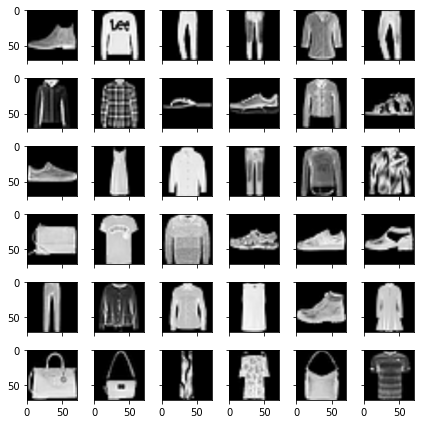

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

ROWS = 6
plt.clf()

# Make small axes for the images
fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

# Plot the images in a matrix ROWS x ROWS
for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS

    # plot the subaxes'
    ax = axes[subplot_row, subplot_col]

    # Pick the image
    label = y_test_xc[i]
    plottable_image = x_test_xc[i]/np.amax(x_test_xc[i])

    # Make an image
    ax.imshow(plottable_image, cmap='gray_r')
    
    # Set the numerical bounds of the x-axis
    ax.set_xbound([0,PIXEL])

# plot it to the webpage
plt.tight_layout()
plt.show()

In [7]:
###### Import Xception

In [8]:
# We will not use default, but 71x71 (closest to NMIST Fashion) and 10 classes (the 10 MNIST Fashion classes)

base_model_XC = tensorflow.keras.applications.Xception(input_shape=(PIXEL,PIXEL,3), weights='imagenet', include_top=False)

In [9]:
base_model_XC.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

##### Which layers to choose

According to https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf
the model conist of 3 parts. Entry flow, Middle flow and Exit flow. As the 1 layer pretrained VGG model used fairly few blocks. We till use only the Entry flow in the Xcetion model. This should be the ending of add_3. However tests were run on add_3 but did not achieve 91.5% score. Also tests were run on Add. In the model below it is based on layers until Add_4. More analysis in the end of the task.
<br><br>
We will use the last best model with the Xception pretrained model

###### Build the model

In [10]:
# Part of the code is adapted from https://maelfabien.github.io/deeplearning/xception/

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D

layer_dict4 = dict([(layer.name, layer) for layer in base_model_XC.layers])

# Getting output tensor of the last VGG layer that we want to include
x4 = layer_dict4['add_4'].output

x4 = SeparableConv2D(768, 3, padding="same")(x4)
x4 = MaxPooling2D(3, strides=2, padding='same')(x4)

x4 = SeparableConv2D(1024, 3, padding="same")(x4)
x4 = MaxPooling2D(3, strides=2, padding='same')(x4)

x4 = Flatten()(x4)
x4 = Dense(256, activation='relu')(x4)
x4 = Dense(256, activation='relu')(x4)
x4 = Dense(256, activation='relu')(x4)
x4 = Dense(10, activation='softmax')(x4)


# Creating new model. 
from keras.models import Model
model4 = Model(base_model_XC.input, x4)


# Make sure that the pre-trained bottom layers are not trainable
# Block1_pool
for layer in model4.layers[:56]:
    layer.trainable = False

# Compile
model4.compile(loss='categorical_crossentropy',
                    optimizer=tensorflow.keras.optimizers.Adam(
                    learning_rate=0.0003,
                    name='Adam'
                    ),
                    metrics=['accuracy'])

model4.summary()

for layer in model4.layers:
    sp = '     '[len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

###### Train the model

In [11]:
batch_size = 32
epochs = 12

early_stopping = EarlyStopping(
    patience=8,
    mode='auto')

start_time = time.time()
history4 = model4.fit(x_train_xc, y_train_xc,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,                      
        callbacks=[early_stopping]
)



elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/12
1435/1435 - 18s - loss: 0.4801 - accuracy: 0.8261 - val_loss: 0.3313 - val_accuracy: 0.8763
Epoch 2/12
1435/1435 - 18s - loss: 0.3114 - accuracy: 0.8878 - val_loss: 0.3192 - val_accuracy: 0.8835
Epoch 3/12
1435/1435 - 18s - loss: 0.2699 - accuracy: 0.9018 - val_loss: 0.2642 - val_accuracy: 0.9020
Epoch 4/12
1435/1435 - 18s - loss: 0.2374 - accuracy: 0.9139 - val_loss: 0.2859 - val_accuracy: 0.8967
Epoch 5/12
1435/1435 - 18s - loss: 0.2112 - accuracy: 0.9225 - val_loss: 0.2574 - val_accuracy: 0.9061
Epoch 6/12
1435/1435 - 18s - loss: 0.1890 - accuracy: 0.9295 - val_loss: 0.2458 - val_accuracy: 0.9147
Epoch 7/12
1435/1435 - 18s - loss: 0.1705 - accuracy: 0.9366 - val_loss: 0.2814 - val_accuracy: 0.9025
Epoch 8/12
1435/1435 - 18s - loss: 0.1557 - accuracy: 0.9418 - val_loss: 0.2689 - val_accuracy: 0.9151
Epoch 9/12
1435/1435 - 18s - loss: 0.1347 - accuracy: 0.9481 - val_loss: 0.3120 - val_accuracy: 0.9114
Epoch 10/12
1435/1435 - 18s - loss: 0.1270 - accuracy: 0.9529 - val_loss:

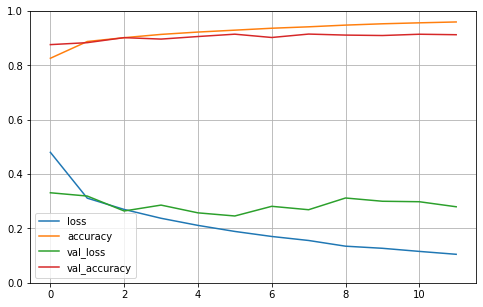

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history4.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
start_time = time.time()

score = model4.evaluate(x_test_xc, y_test_xc, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Test loss: 0.3293016254901886
Test accuracy: 0.901199996471405
Elapsed time: 0:00:03.12


###### Analysis

The target accuracy was 91,5%. This was not achieve. Several models setups were tested. Taking the pre-trained model 
till Add and Add_3 and Add_4. Running without own Dense layers. running with own Convolution layers with and without MaxPooling.
It would be interesting to see how a model with 92%+ would be run. In the book, they indicate that 95% should be possible to 
achieve for certain images. 
<br><br>
A model that was a 2 step, step 1 with locked weights, and step 2 afterwards with all layers trainable, was tried, but 
I could not get around errors on the GPU.


###### A model for step 2 (Xception)  that could not be tested due to error messages from the GPU (to little memory)

In [ ]:
# Adapted from the book "Hand on Machine Learning with Scikit-learn Keras & Tensorflow", Geron, p482
start_time = time.time()

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D, SeparableConv2D, BatchNormalization, Activation, MaxPooling2D

layer_dict6 = dict([(layer.name, layer) for layer in base_model_XC.layers])

# Getting output tensor of the last VGG layer that we want to include
x6 = layer_dict6['add_4'].output

x6 = GlobalMaxPooling2D()(x4)
x6 = Flatten()(x4)
x6 = Dense(10, activation='softmax')(x4)

# Creating new model. 
from keras.models import Model
model6 = Model(base_model_XC.input, x4)

# Make sure that the pre-trained bottom layers are not trainable
# Block1_pool
for layer in model6.layers[:56]:
    layer.trainable = False

# Compile
model6.compile(loss='categorical_crossentropy',
                    optimizer=tensorflow.keras.optimizers.Adam(
                    learning_rate=0.003,
                    name='Adam'
                    ),
                    metrics=['accuracy'])

model6.summary()

for layer in model6.layers:
    sp = '     '[len(layer.name)-9:]
    print(layer.name, sp, layer.trainable)

batch_size = 224
epochs = 5

early_stopping = EarlyStopping(
    patience=1,
    mode='auto')

history6 = model6.fit(x_train_xc, y_train_xc,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,                      
        callbacks=[early_stopping]
)

# Set (all the non-trainable) layers to trainable
for layer in model6.layers[:56]:
    layer.trainable = True

# Compile Again, LOWER learning rate, not to mess with existing weights
model6.compile(loss='categorical_crossentropy',
                    optimizer=tensorflow.keras.optimizers.Adam(
                    learning_rate=0.00003,
                    name='Adam'
                    ),
                    metrics=['accuracy'])

# CONTINUE TRAINING

# New epochs
epochs = 15

# New Paitience
early_stopping = EarlyStopping(
    patience=4,
    mode='auto')

# Train
history6 = model6.fit(x_train_xc, y_train_xc,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.1,                      
        callbacks=[early_stopping]
)


elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))